**Part 1: Build a Basic Chatbot**

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}
                         
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
# Next, add an entry point. 
# This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")
# Similarly, set a finish point. 
# This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

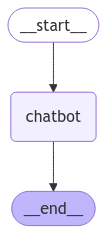

In [4]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Now let's run the chatbot!
def stream_graph_updates(user_input: str):
    # 注意：这里传入的 input，可以视为 State 的初始值
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi there! How can I help you today?
Goodbye!


**Part 2: 🛠️ Enhancing the Chatbot with Tools**

接下来增强 bot 能力，集成进来一个 web search tool。

使用 Tavily，它提供了一个图，看着挺好，可以参考（Empower your chatbots to deliver precise, up-to-date responses by accessing a wide range of information through Tavily’s robust search capabilities.）

![Tavily Graph Example](https://tavily.com/_next/static/media/app-red-lg.25f93dc4.svg "Tavily Graph Example")

In [1]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

In [10]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools:list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict) -> dict:
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [12]:
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot", 
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

graph = graph_builder.compile()

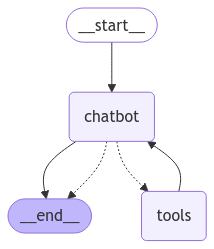

In [7]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# Now let's run the chatbot!
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        # Question: langgraph 和 dify 对比
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: [{'text': '我将帮您对比 LangGraph 和 Dify 这两个工具。让我搜索一下最新的信息。', 'type': 'text'}, {'id': 'toolu_01KLUY4DdjQNetCjHV8XczM2', 'input': {'query': 'LangGraph vs Dify AI development platforms comparison'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://www.restack.io/p/dify-answer-vs-langgraph-cat-ai", "content": "Dify and LangGraph are both platforms designed to facilitate the development of applications utilizing large language models (LLMs), but they offer distinct features that cater to different user needs. docs.dify.ai docs.dify.ai/guides/monitoring/integrate-external-ops-tools/integrate-langsmith docs.dify.ai docs.dify.ai/guides/application-publishing/developing-with-apis docs.dify.ai docs.dify.ai/learn-more/extended-reading/what-is-llmops Dify provides a robust API that allows developers to integrate large language model (LLM) capabilities into their applications seamlessly. Secure Access: Dify enables frontend applications to access LLM cap

langGraph 提供了一个简化的版本，使用 `ToolNode` 替换 `BasicToolNode`，使用 `tools_condition` 替换 `route_tools`。

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

**Part 3: Adding Memory to the Chatbot**

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [17]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory)

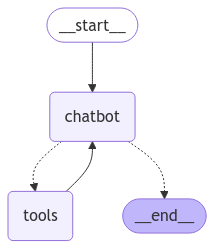

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
# First, pick a thread to use as the key for this conversation.
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Tian Zhiwei."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Tian Zhiwei.
================================== Ai Message ==================================

Hello Tian Zhiwei! It's nice to meet you. How are you doing today? Is there anything I can help you with?


In [20]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I will remember your name as Tian Zhiwei. I appreciate you introducing yourself. Is there something specific I can assist you with today?


内存记忆必须是运行在同一个进程中才可以。试验了下，即使使用同一个 thread_id，在命令行两次执行 `python test.py` 就无法实现记忆能力。

In [21]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I do not have any prior context to remember your name. Each conversation starts fresh, and I do not have the ability to retain information from previous interactions. If you'd like, you can simply tell me your name in this conversation, and I'll be happy to address you by it during our chat.


In [24]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Tian Zhiwei.', additional_kwargs={}, response_metadata={}, id='bae8e4cd-1571-479a-b8a6-51800aefe34d'), AIMessage(content="Hello Tian Zhiwei! It's nice to meet you. How are you doing today? Is there anything I can help you with?", additional_kwargs={}, response_metadata={'id': 'msg_01AttrpCogPfQycLgeHakovL', 'model': 'claude-3-5-haiku-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 381, 'output_tokens': 34}}, id='run-456967db-321e-46a7-b5ad-c49af2538120-0', usage_metadata={'input_tokens': 381, 'output_tokens': 34, 'total_tokens': 415, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='e7193579-33ae-45d7-aee3-bbb8cfe9bef4'), AIMessage(content='Yes, I will remember your name as Tian Zhiwei. I appreciate you i

In [25]:
snapshot.next

()

完整的代码示例：

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

**Part 4: Human-in-the-loop**

In [30]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]

llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [31]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

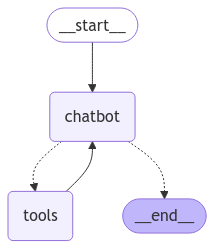

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
import uuid

thread_id = uuid.uuid4()

user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_016JGKPzKFQTEjU3rohQaiHi', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide advice on the key considerations, best practices, and potential challenges in designing and implementing an effective AI agent? I'm interested in understanding the technical architecture, development process, and important factors to consider for creating a robust and intelligent agent."}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016JGKPzKFQTEjU3rohQaiHi)
 Call ID: toolu_016JGKPzKFQTEjU3rohQaiHi
  Args:
    query: I'm looking for expert guidance on bui

大模型确实给出了 “human_assistance” 这个 tool 的调用，但是在执行 tool 时，被中断了，这个貌似是预期内的？但是没有出现需要人工介入的地方，human_response 也没有返回值，从 langSmith 上看是有报错的：GraphInterrupt。

In [37]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [38]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_016JGKPzKFQTEjU3rohQaiHi', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide advice on the key considerations, best practices, and potential challenges in designing and implementing an effective AI agent? I'm interested in understanding the technical architecture, development process, and important factors to consider for creating a robust and intelligent agent."}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016JGKPzKFQTEjU3rohQaiHi)
 Call ID: toolu_016JGKPzKFQTEjU3rohQaiHi
  Args:
    query: I'm looking for expert guidance on building an AI agent. Could you provide advice on the key considerations, best practices, and potential challenges in designing and implementing an effective AI agent? I'm inte

完整的代码示例：

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

**Part 5: Customizing State**

In [49]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [50]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt({
        "question": "Is this correct?",
        "name": name,
        "birthday": birthday,
    })
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"
    
    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [51]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [52]:
import uuid

thread_id = uuid.uuid4()

In [53]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)

config = {"configurable": {"thread_id": thread_id}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "I'll search for information about when LangGraph was released.", 'type': 'text'}, {'id': 'toolu_011uxfbdRyh31kGxGLEnGGVt', 'input': {'query': 'LangGraph release date launch'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011uxfbdRyh31kGxGLEnGGVt)
 Call ID: toolu_011uxfbdRyh31kGxGLEnGGVt
  Args:
    query: LangGraph release date launch
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pypi.org/project/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. The simp

In [54]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on the search results, it appears that LangGraph was released relatively recently, with versions like 0.2.70 being uploaded in early 2024. However, to ensure I have the most accurate information, I'll use the human assistance tool:", 'type': 'text'}, {'id': 'toolu_01URpCvDhDms9UL2s32sTUpF', 'input': {'name': 'LangGraph Release Date', 'birthday': '2024-01-01'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01URpCvDhDms9UL2s32sTUpF)
 Call ID: toolu_01URpCvDhDms9UL2s32sTUpF
  Args:
    name: LangGraph Release Date
    birthday: 2024-01-01
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

Based on the human assistance verification, LangGraph was offi

In [56]:
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

langGraph 提到：在任何节点包括 interrupted 时，都可以修改 state

In [57]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': UUID('33c10ff4-5027-40ff-b52b-6e7d9ab30077'),
  'checkpoint_ns': '',
  'checkpoint_id': '1efe9e53-977d-65cc-8008-48511356f74a'}}

In [58]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

完整的代码如下：

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt



class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

**Part 6: Time Travel**

能够回撤到之前的某个节点，重新对话

In [81]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-haiku-latest")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [82]:
import uuid

thread_id = uuid.uuid4()

In [83]:
config = {"configurable": {"thread_id": thread_id}}
events = graph.stream(
    {
        "messages": [
             {
                "role":"system",
                "content":"you should use tavily_search_results_json tool just once"
            },
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for information about LangGraph to help you learn more about it.", 'type': 'text'}, {'id': 'toolu_01CqytMS75eAhWNnCu51Vfmf', 'input': {'query': 'LangGraph AI library LangChain what is it used for'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01CqytMS75eAhWNnCu51Vfmf)
 Call ID: toolu_01CqytMS75eAhWNnCu51Vfmf
  Args:
    query: LangGraph AI library LangChain what is it used for
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and e

In [84]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for some guidance on building an autonomous agent with LangGraph to provide you with some practical insights.', 'type': 'text'}, {'id': 'toolu_01Jht3mbENSCgtN44mBMQUu7', 'input': {'query': 'How to build autonomous agent with LangGraph example tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Jht3mbENSCgtN44mBMQUu7)
 Call ID: toolu_01Jht3mbENSCgtN44mBMQUu7
  Args:
    query: How to build autonomous agent with LangGraph example tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832", 

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 8:
        # We are somewhat arbitrarily selecting a specific state 
        # based on the number of chat messages in the state.
        to_replay = state

Num Messages:  9 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('chatbot',)
-----------------------------------------

In [86]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': UUID('676a9a98-1ced-46fd-a216-5594f5ac7d6f'), 'checkpoint_ns': '', 'checkpoint_id': '1efe9fce-7de4-674c-8007-ecaf17df8fb3'}}


In [87]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@lorevanoudenhove/how-to-build-ai-agents-with-langgraph-a-step-by-step-guide-5d84d9c7e832", "content": "In this step, we’ll define how the AI agent manages its state (the ongoing context of the conversation) and ensure it responds appropriately to the user’s input and tool output. This involves creating a template for the conversation, specifying the tools that the assistant will use, and configuring how the AI agent will respond to user input and trigger different functions (like calculating solar savings). This step ensures that the AI assistant can access and trigger the tools as needed during the conversation, creating a seamless interaction between the user and the assistant. By following these steps, you have successfully created an AI assistant using LangGraph that can calculate solar panel energy savings based on user inputs."}, {"url":